## Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import operator
from numpy import linalg as la
from copy import deepcopy

from sklearn.model_selection import train_test_split

from sklearn.metrics.cluster import contingency_matrix
from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering


## Calculate Eigen values and vectors

In [17]:
def calculate_eigens(df):
    #finding atttr_wise(col_wise) mean and std
    
    mn = np.mean(df)
    std = np.std(df)
    
#     print(df)
    #normalizing data to (0-1) range
    normalised = (df - mn)/std
    #finding covariance matrix to make mat of order(attr * attr)
    cov_mat = np.cov(normalised.T)
#     print(cov_mat.shape)
    #calculating eval and evec
    evalue,evec = la.eig(cov_mat)
#     print(evalue)
#     print(evec)
#     print(normalised)
    
    return evalue,evec,normalised

## Selecting  dimensions with 10% tolerance using PCA

In [18]:
def select_dimensions(mydict,evalue,evec,ndata):
    #storing eval,evec in dict as key-value
    for i in range (len(evalue)) :
        mydict[evalue[i]] = evec[i]
    
    #summing evalues 
    evalue_sum = sum(evalue)
    #print(evalue_sum)
    
    #sorting evalues in decreasing order 
    evalue_sorted = sorted(evalue, reverse = True)
    
    min_val = .90
    curr_val = 0
    
    #sel_dimensions list till tolerance becomes less than 0.1
    dim_list = []
    
    
    for i in range (len(evalue_sorted)) :
        #while curr_tolerance is less than .9, include dimension in dim_list
        curr_val = curr_val + evalue_sorted[i]/evalue_sum
        dim_list.append(mydict[evalue_sorted[i]])
        if curr_val > 0.9 :
            break
        
#     print (curr_val)
#     print (dim_list)
    
    #final reduced dimensions 
    dim_list = np.asarray(dim_list)
    dim_list = dim_list.T
    dimensions = np.dot(ndata,dim_list)
    
#     print(ndata.shape, dim_list.shape, dimensions.shape)
    
    #final reduced data is of dimensions (rows * reduced_attr)
    return dimensions


## K-means on Reduced Dimensions

In [19]:
def k_means(k,dimensions) :
    rows = dimensions.shape[0]
    cols = dimensions.shape[1]
    
    mn = np.mean(dimensions, axis = 0)
    std = np.std(dimensions, axis = 0)
    centers = np.random.randn(k,cols)*std + mn
    
#     plt.scatter(centers[:,0], centers[:,1], marker='+', c='r', s=150)
    
    # to store old centers
    co = np.zeros(centers.shape)
    # to Store new centers
    cn = deepcopy(centers) 

    clusters = np.zeros(rows)
    distances = np.zeros((rows,k))

    error = np.linalg.norm(cn - co)

    # When, after an update, the estimate of that center stays the same, exit loop
    while error != 0:
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(dimensions - cn[i], axis=1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        co = deepcopy(cn)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            cn[i] = np.mean(dimensions[clusters == i], axis=0)
        error = np.linalg.norm(cn - co)
    # centers_new   
#     plt.scatter(cn[:,0], cn[:,1], marker='+', c='g', s=150)
#     print(clusters)
#     print(np.unique(clusters))
    
    #
    cmat=contingency_matrix(clusters,lclass)
#     print(cmat)

    for i,item in enumerate(cmat):
        print("Purity of clusters :",i," :", max(item)*100/sum(item))
    
    pure=0
    for row in cmat:
#         print(max(row))
        pure+=max(row)
    purity0=pure/len(label)
    
    return purity0
    

## Gaussian Mixture Model

In [20]:
def GMM_fun(dimensions) :
    
    GMM=GaussianMixture(n_components=5).fit(dimensions)
    gmmlabel=GMM.predict(dimensions)
    
    np.unique(gmmlabel)
    cmat=contingency_matrix(gmmlabel,lclass)

    for i,item in enumerate(cmat):
        print("Purity of clusters :",i," :", max(item)*100/sum(item))

    pure1=0
    for i in cmat:
        pure1+=max(i)
    #     print(max(i))
    purity1=pure1/len(label)
    print('GMM Purity:', purity1)
    
    return purity1

## Hierarchial Clustering

In [21]:
def hierarchial_cluster(dimensions) :
    cc=AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='single')
    aclabel=cc.fit_predict(dimensions)
    np.unique(aclabel)
    
    cmat2=contingency_matrix(aclabel,lclass)
    
    for i,item in enumerate(cmat2):
        print("Purity of clusters :",i," :", max(item)*100/sum(item))

    pure2=0
    for i in cmat2:
        pure2+=max(i)
    purity2=pure2/len(label)
    print('Hierarchical Purity:', purity2)
    
    return purity2
 

## Reading data from files

In [22]:
df = pd.read_csv('intrusion_detection/data.csv') 
# df = df.head(1000)
# print(df)
label = df['xAttack']
df = df.drop(['xAttack'],axis =1)


# print(df)
#calculating eigens values and vectors
evalue,evec,ndata = calculate_eigens(df)

#store e_val,evec in dict as key-value
mydict = {}

#selecting dimensions wtih 10% tolerance
dimensions = select_dimensions(mydict,evalue,evec,ndata)
print('Reduced Dimensions :',dimensions.shape[1])


#converting unique vals of label [xAttack] attr into integer categories
uv = np.unique(label)
# print(uv)
cat = [0,1,2,3,4]
#converted label data into int class list 
lclass=[]
for i in range(len(label)):
    if label[i]=='dos':
        lclass.append(cat[0])
    if label[i]=='normal':
        lclass.append(cat[1])
    if label[i]=='probe':
        lclass.append(cat[2])
    if label[i]=='r2l':
        lclass.append(cat[3])
    if label[i]=='u2r':
        lclass.append(cat[4])
# print(lclass)

# kmeans on reduced dimenasions
k = 5
purity0 = k_means(k,dimensions)
print('K-means Purity is:', purity0)

#GMM_fun
purity1 = GMM_fun(dimensions)

#Hierarchial clustering
purity2 = hierarchial_cluster(dimensions)



Reduced Dimensions : 14
Purity of clusters : 0  : 95.0617283951
Purity of clusters : 1  : 84.4781445138
Purity of clusters : 2  : 50.4811250925
Purity of clusters : 3  : 88.9601691928
Purity of clusters : 4  : 98.2631350413
K-means Purity is: 0.87190975278
Purity of clusters : 0  : 99.7578692494
Purity of clusters : 1  : 45.6643792888
Purity of clusters : 2  : 45.1342766388
Purity of clusters : 3  : 100.0
Purity of clusters : 4  : 92.4021040327
GMM Purity: 0.781342507401
Purity of clusters : 0  : 100.0
Purity of clusters : 1  : 53.4475169074
Purity of clusters : 2  : 100.0
Purity of clusters : 3  : 100.0
Purity of clusters : 4  : 100.0
Hierarchical Purity: 0.534642771422


## PIE Chart

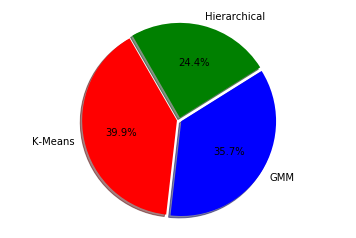

In [23]:
import matplotlib.pyplot as plt
slices_hours = [purity0, purity1, purity2]
activities = ['K-Means', 'GMM', 'Hierarchical']
explode = (0.025, 0.025, 0.025)
colors = ['red', 'blue','green']
fig1, ax1 = plt.subplots()
ax1.pie(slices_hours, explode=explode,colors=colors, labels=activities, autopct='%1.1f%%',
        shadow=True, startangle=120)
ax1.axis('equal') 
plt.show()